# Help a friend avoid a long drive to visit family

AKA: How to use data to your advantage. 

AKA: Don't do this. 

AKA: Really, don't do this. 

### Story

Your friend doesn't want to drive to Maryland, so he's trying to see if the COVID death count there is too high. 

Find a way to convince his relatives to wear masks. 

### Methodology

Use the CDC data on excess deaths! Figure out a way to make Maryland look more dangerous than Texas. 

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "white"}

import io
import math
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image
from PIL import Image as PILImage

state_names = pd.read_csv('states.csv').set_index('State').to_dict()['Abbreviation']

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 14 (delta 9), reused 14 (delta 9), pack-reused 0
Unpacking objects: 100% (14/14), done.
From https://github.com/CSSEGISandData/COVID-19
   a6325176..1ce63f33  web-data   -> origin/web-data
Already up to date.


In [2]:
def get_excess_deaths():
    rawdata = pd.read_csv('https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=')
    rawdata = rawdata[rawdata['Jurisdiction'] != 'United States']
    gte2020 = rawdata[rawdata['Year'] == 2020].groupby(['Jurisdiction', 'Week'])[['Number of Deaths']].sum()
    maxweek = gte2020.reset_index()['Week'].max()
    lt2020 = rawdata[(rawdata['Year'] < 2020) & (rawdata['Week'] <= maxweek)].groupby(['Jurisdiction', 'Year', 'Week']).sum()[['Number of Deaths']].groupby(['Jurisdiction', 'Week']).mean()#.rename(columns={'Number of Deaths': 'Avg'})

    compareData = lt2020.copy().rename(columns={'Number of Deaths':'Average'})

    compareData['2020'] = gte2020['Number of Deaths']

    compareData = compareData.fillna(0)

    compareData['Difference'] = (compareData['2020'].div(compareData['Average']) * 100) - 100

    compareData = compareData.reset_index()

    pivottable = compareData.pivot(index='Week', columns='Jurisdiction', values='Difference')

    pivottable['Week Ending'] = pd.to_datetime(rawdata[rawdata['Year'] == 2020].groupby(['Week'])['Week Ending Date'].max())
    pivottable = pivottable.reset_index().set_index('Week Ending').drop(['Week'], axis=1)
    pivottable['New York'] = pivottable['New York'] + pivottable['New York City']
    pivottable = pivottable.drop(['New York City', 'Puerto Rico'], axis=1)
    return pivottable


In [70]:
# Load the data and cache it so you don't have to keep getting the data again and again. 
excess_deaths_raw = get_excess_deaths()

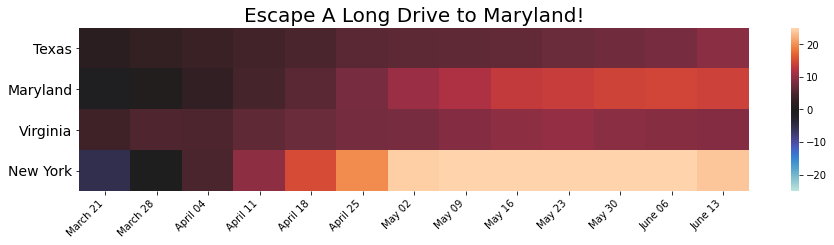

In [97]:
# Copy the memory-resident version of the code. 
excess_deaths = excess_deaths_raw.copy()
interested_states = ['Texas', 'Maryland', 'Virginia', 'New York']
excess_deaths = excess_deaths[interested_states]

# Clip the data because NY=Death
excess_deaths = excess_deaths.clip(-50, 50)

# Be sure to add a really big rolling window to make the data at the end look worse than it is.
excess_deaths = excess_deaths.rolling(window=12).mean().dropna()

# Make the chart oblong. Oblong is a fun word.
fig, ax = plt.subplots(figsize=(15, 3))

# Use a diverging colormap because it worked better when the window was smaller, and makes it look like 
# _someone_ is getting this COVID thing right... Also because you're lazy and this isn't your day job.
ax = sns.heatmap(excess_deaths.transpose(), ax=ax, cmap='icefire', vmin=-25, vmax=25)
ax.set_xticklabels([x.strftime('%B %d') for x in excess_deaths.index], rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size=14)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Escape A Long Drive to Maryland!', size=20);
